In [0]:
d

# Machine Learning in Python \- Group 14

_Contributors: Sondre W, Tomas M, Emily M, Fraser Singh._



In [74]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd


# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Plotting and Figure defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
styles = [dict(selector="caption", props=[("font-size","150%"),("font-weight", "bold")])]

# sklearn modules that are necessary
import sklearn
from collections import Counter
from fuzzywuzzy import fuzz
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from matplotlib.colors import ListedColormap

#Suppress specific warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<span style='color:#f44336'>QUESTIONS FOR MLP PROJECT:</span>

1. <span style='color:#f44336'>Collect \(neg\)RMSE from each model that are testing </span>
2. <span style='color:#f44336'>Add figure legends for each output styles df.style.set\_caption\('&lt;caption&gt;'\).set\_table\_styles\(styles\)</span>  



## Abstract

This project consisted of analysis of pre\-existing data on the US rendition of the TV mockumentary "The Office", combined with a dataset containing information on the duration and names of guest stars in each episode. The full set of data was then fit to various regression models with <span style='font-family:Courier'>imdb\_rating </span>as a response, with an aim to determine what combination of episode features might result in a high rating in the event of a reunion episode. We find a strong positive correlation between <span style='font-family:Courier'>imdb\_rating </span>and episode duration, number of lines spoken in the episode, number of directed cuts, and Michael appearing as a character.



## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw

The aim of this work is to assess a public dataset which details the US TV show 'The Office' and to ascertain the main influencing factors on a given episode's 'IMDb rating', which is determined by public vote through IMDB's website \(an abbreviation of Internet Movie Database\). The Office, produced by NBC, is one of the most watched and critically acclaimed shows of American TV over the past 20 years, potentially making a reunion episode highly lucrative for NBC. Given a dataset of all episodes for "The Office", we set out to determine the factors which will maximise the IMDb rating for an upcoming reunion episode of the show. Previewed below, the provided dataset contained 186 observations \(episodes\) with the following variables describing various metrics of the episodes row by row:

<span style='font-family:Courier'>season: </span>Which season the episode was in

<span style='font-family:Courier'>episode</span>: The episode number within the season

<span style='font-family:Courier'>episode\_name</span>

<span style='font-family:Courier'>director</span>: director\(s\) on the given episode

<span style='font-family:Courier'>writer</span>: writer\(s\) on the given episode

<span style='font-family:Courier'>imdb\_rating</span>: average IMDb rating for the given episode

<span style='font-family:Courier'>total\_votes</span>: number of votes on IMDb for the given episode

<span style='font-family:Courier'>air\_date</span>

<span style='font-family:Courier'>n\_lines</span>: Number of spoken lines within episode

<span style='font-family:Courier'>n\_directions</span>: number of scripted actor directions \(e.g. \[actor1 looks at actor2\]\)

<span style='font-family:Courier'>n\_words</span>: number of spoken words within the episode

<span style='font-family:Courier'>n\_speak\_char</span>: number of characters who spoke within the episode

<span style='font-family:Courier'>main\_chars</span>: main characters in the episode



In [75]:
# Load standard data
data = pd.read_csv("the_office.csv"); data.head(2)

season  episode   episode_name    director  \
0       1        1          Pilot  Ken Kwapis   
1       1        2  Diversity Day  Ken Kwapis   

                                        writer  imdb_rating  total_votes  \
0  Ricky Gervais;Stephen Merchant;Greg Daniels          7.6         3706   
1                                   B.J. Novak          8.3         3566   

     air_date  n_lines  n_directions  n_words  n_speak_char  \
0  2005-03-24      229            27     2757            15   
1  2005-03-29      203            20     2808            12   

                                          main_chars  
0  Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...  
1  Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...

### 1.1 Introducing and additional data:

In addition to the provided dataset, we have decided to include another dataset found online \(subsequently referred to as the 'Saleem dataset ' <span style='color:#f44336'>REFERENCE\) </span>with additional metrics about 'The Office', \(found at: [[https://www.datainsightonline.com/post/exploring\-interesting\-information\-from\-the\-office\-dataset](https://www.datainsightonline.com/post/exploring-interesting-information-from-the-office-datasetta)](https://www.datainsightonline.com/post/exploring-interesting-information-from-the-office-dataset)\).



In [76]:
#Load in the Saleem dataset found online
edata = pd.read_csv("the_office_series.csv"); edata.head(2)

Unnamed: 0  Season   EpisodeTitle  \
0           0       1          Pilot   
1           1       1  Diversity Day   

                                               About  Ratings  Votes  \
0  The premiere episode introduces the boss and s...      7.5   4936   
1  Michael's off color remark puts a sensitivity ...      8.3   4801   

   Viewership  Duration            Date GuestStars    Director  \
0        11.2        23   24 March 2005        NaN  Ken Kwapis   
1         6.0        23   29 March 2005        NaN  Ken Kwapis   

                                            Writers  
0  Ricky Gervais |Stephen Merchant and Greg Daniels  
1                                       B. J. Novak

## 2.Exploratory Data Analysis and Feature Engineering



<span style='color:#f44336'>**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**</span>



### **2.1 Exploratory Data Analysis**

We start by plotting the episodes by air date and imdb rating, with the colours representing the season in which each episode appeared. It seems the median rating for each season was slowly increasing for the first 4 seasons while declining more rapidly from season 6. However, we note that seasons 5,6,7,8,9 each have some large outliers in the in terms of ratings. We aim to make recommendations for a reunion episode of "The Office" airing on an unspecified future date and so the air date for each episode is likely to be irrelevant to further exploration in this report. The plot is useful, however, as a way of visualising how ratings varied with season throughout the lifetime of the show, while also illuminating the fact that there were outliers, in terms of ratings, in some of the later seasons.



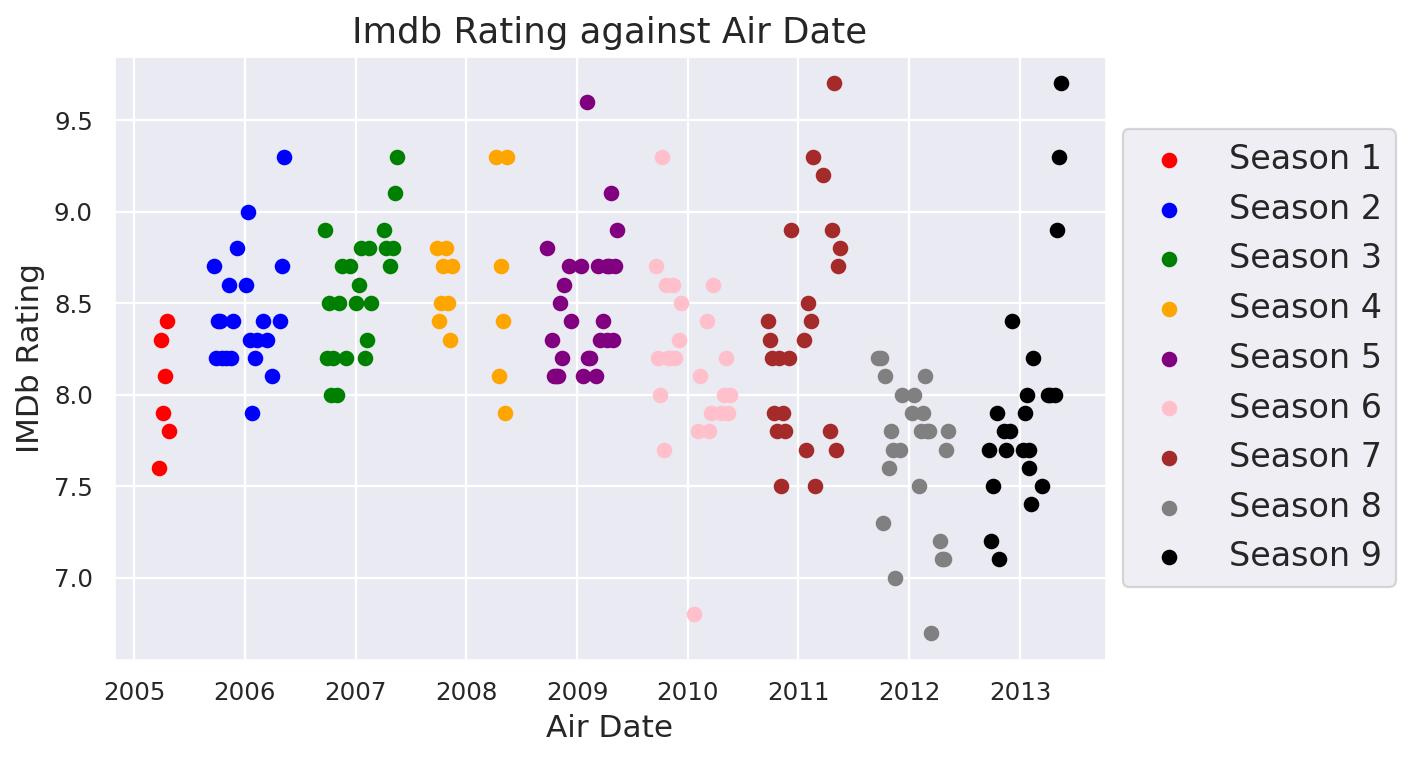

In [77]:
data['air_date_datetime'] = pd.to_datetime(data['air_date'])

# Create a dictionary that maps each season to a color
colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'orange', 5: 'purple', 6: 'pink', 7: 'brown', 8: 'gray', 9: 'black'}

# Plot data for each season
fig, ax = plt.subplots()
for season in range(1, 10):
    season_data = data[data['season'] == season]
    ax.scatter(season_data['air_date_datetime'], season_data['imdb_rating'], color=colors[season], label=f'Season {season}')

# Add labels and legend
ax.set_xlabel('Air Date', size=14)
ax.set_ylabel('IMDb Rating', size=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 15})
ax.set_title("Imdb Rating against Air Date", size=16)

# Show
plt.show()

#Remove 'air_date_datetime' column from df in order to ensure we are working only on the data we actually imported
data = data.drop(['air_date_datetime'], axis=1)

From the Saleem dataset we selected the following columns:

- _GuestStars_ \- extra stars that appeared on that episode
- _Duration_ \- duration of episodes in minutes

While <span style='font-family:Courier'>Viewership</span> was one of the variables in the extra data set that may be correlated we <span style='font-family:Courier'>imdb\_rating</span>, we chose not to include it in our dataset for several reasons, including the fact that NBC is unlikely to have direct control over viewership prior to an episode's release. As seen below, some data cleaning was required as the indexing from each data source was conflicting, necessitating manual corrections.



In [78]:
#Select only columns of extra data frame that contains new, relevant information.
#Include date and EpisodeTitle for now for easier interpretation
e_col = edata[["EpisodeTitle", "Date", "Duration","GuestStars"]]

#Check if number of rows in main dataset are same as in extra set
print(f"Number of rows in main data frame:{data.shape[0]} \nNumber of rows in extra data frame:{edata.shape[0]}\n\n")

# count the number of occurrences of each date in each dataset
date_counts_edata = e_col['Date'].value_counts()
date_counts_data = data['air_date'].value_counts()

# filter the dates that appear more than once
duplicates_edata = date_counts_edata[date_counts_edata > 1].index.tolist()
duplicates_data = date_counts_data[date_counts_data > 1].index.tolist()

#Print observations with a repeated date in Saleem dataset
Extra_duped=pd.DataFrame(columns=['EpisodeTitle','Date'])
for date in duplicates_edata:
        dupedI=edata[edata["Date"]==date][["Date","EpisodeTitle"]]
        Extra_duped=Extra_duped.append(dupedI, ignore_index=True)
print(f"Episode names of episodes that were released on same day in Saleem data:")
display(Extra_duped)
#Print observations with a repeated date in main dataset
duped=pd.DataFrame(columns=["episode_name","air_date"])
for date in duplicates_data:
        dupedI=data[data["air_date"]==date][["air_date","episode_name"]]
        duped=duped.append(dupedI, ignore_index=True)
print(f"Episode names of episodes that were released on same day in Original data:")
display(duped)

Number of rows in main data frame:186 
Number of rows in extra data frame:188


Episode names of episodes that were released on same day in Saleem data:


EpisodeTitle              Date
0              Niagara: Part 1    8 October 2009
1              Niagara: Part 2    8 October 2009
2         The Delivery: Part 1      4 March 2010
3         The Delivery: Part 2      4 March 2010
4                   Dream Team      9 April 2009
5  Michael Scott Paper Company      9 April 2009
6              Junior Salesman   31 January 2013
7                    Vandalism   31 January 2013

Episode names of episodes that were released on same day in Original data:


episode_name    air_date
0                       Dream Team  2009-04-09
1  The Michael Scott Paper Company  2009-04-09
2                  Junior Salesman  2013-01-31
3                        Vandalism  2013-01-31

The first observation we make is that the Saleem data has two more rows than the main data frame, which disrupts the indexing of said episodes. We need both datasets to have the same number of entries \(episodes\) in order to properly combine them. The code above investigates this discrepancy by printing entries containing a repeated date. We note that both datasets confirm that the episodes "Dream Team" and "The Michael Scott Paper Company" shared release date \(9 April 2009\). Similarly, both datasets confirm that the episodes "Junior Salesman" and "Vandalism" were released on the same date \(31 January 2013\), thus, no cleaning is needed for these dates. In the Saleem   
dataset, the two\-part episodes "Niagara" and "The Delivery" have been split into two observations. We check what these dates correspond to in the main dataset.


In [79]:
(data[data["air_date"]=='2009-10-08'][["episode_name", "air_date"]]).append((data[data["air_date"]=='2010-03-04'][["episode_name", "air_date"]]), ignore_index=True)

episode_name    air_date
0       Niagara (Parts 1&2)  2009-10-08
1  The Delivery (Parts 1&2)  2010-03-04

In the main dataset, we note that these two\-part episodes have been identified with one observation each in the main dataset. From above, we recall that the extra dataset had two additional observations, compared to the main one. In order to properly combine the data, we thus need to combine the entries corresponding to "Niagara" and "The Delivery" in the Saleem dataset. To do so, we first print the entries corresponding to these episodes for the relevant variables in the extra dataset.


In [80]:
(e_col[e_col["Date"]==' 8 October 2009']).append((e_col[e_col["Date"]==' 4 March 2010']))

EpisodeTitle             Date  Duration     GuestStars
94        Niagara: Part 1   8 October 2009        30            NaN
95        Niagara: Part 2   8 October 2009        19            NaN
107  The Delivery: Part 1     4 March 2010        30            NaN
108  The Delivery: Part 2     4 March 2010        30  Mellisa Rauch

We see that "Niagara: Part 1" and "Niagara: Part 2" both had no guest stars. However, the duration of each part was different. This raises the question of what duration to assign to the observation \(episode\) in which we will combine these two. A quick look at the main dataset confirms that there were some episodes, such as "Fun Run", "Dunder Mifflin Infinity", and "Launch Party", which had two parts, but that were treated as a single observation in both sets of data. The Saleem dataset indicates that each of these episodes had a total duration of 42 minutes. The median duration of each episode is checked with 


In [81]:
print("Median episode duration:", e_col['Duration'].median())

Median episode duration: 23.0


A duration of 42 minutes is almost 20 minutes longer than the median duration of each episode. We thus conclude that the extra data, when it combines data for two\-part episodes, simply adds the duration of each part. Hence, to combine the data for episodes "Niagara: Part 1" and "Niagara: Part 2" into a single entry "Niagara", we simply add the durations \(as opposed to, for example, taking an average\). The viewership and Guest Stars entries are left untouched as they were the same for both parts.


In [82]:
e_col.at[94, "EpisodeTitle"] = "Niagara (Parts 1&2)"
e_col.at[94, "Duration"] = e_col["Duration"][94:96].sum()
e_col = e_col.drop([95])

Similarly, we note that "The Delivery: Part 1" and "The Delivery: Part 2", both released 4 March 2010, have the same viewership and duration. However, part two features guest star Mellisa Rauch. As for "Niagara", we simply add up the duration of each part when combining these two episodes into a single observation "The Delivery". We conclude that Mellisa Rauch was a guest star in the overall episode, and so we include her name in the "GuestStars" column for the new observation. Finally, we reset the index of the e\_col dataset as we have deleted some rows.


In [83]:
e_col.at[108, "EpisodeTitle"] = "The Delivery (Parts 1&2)"
e_col.at[108, "Duration"] = e_col["Duration"][107:109].sum()
e_col = e_col.drop([107])
e_col=e_col.reset_index()
e_col = e_col.drop(["index"], axis=1)

We are now interested to see whether there are any remaining two\-part episodes that have not been combined to a single observation. We want all such episode to be combined for uniformity of the data. In both datasets, we print any observations for which the episode\_name contains "Part 1" or "Part 2".


In [84]:
two_part_index1 = []
two_part_index2 =[]
for i in range(data.shape[0]):
    if ("Part 1" in data["episode_name"][i]) or ("Part 2" in data["episode_name"][i]):
        two_part_index1.append(i)
    if ("Part 1" in e_col["EpisodeTitle"][i]) or ("Part 2" in e_col["EpisodeTitle"][i]):
        two_part_index2.append(i)

print("Original Data:")
display(pd.DataFrame(data.iloc[two_part_index1]))

print("Saleem Data:")
display(pd.DataFrame(e_col.iloc[two_part_index2]))

Original Data:


season  episode              episode_name    director        writer  \
78       5       16  Lecture Circuit (Part 1)  Ken Kwapis  Mindy Kaling   
79       5       17  Lecture Circuit (Part 2)  Ken Kwapis  Mindy Kaling   

    imdb_rating  total_votes    air_date  n_lines  n_directions  n_words  \
78          8.2         1838  2009-02-05      237            52     2792   
79          8.2         1808  2009-02-12      252            60     2412   

    n_speak_char                                         main_chars  
78            14  Andy;Creed;Dwight;Jim;Kelly;Michael;Oscar;Pam;...  
79            17  Angela;Creed;Dwight;Jim;Kelly;Kevin;Meredith;M...

Saleem Data:


EpisodeTitle               Date  Duration GuestStars
78  Lecture Circuit: Part 1    5 February 2009        30        NaN
79  Lecture Circuit: Part 2   12 February 2009        30        NaN

In each dataset, we combine observations 78 and 79, corresponding to "Lecture Circuit" parts 1 and 2, into a new observation by considering each variable separately. We shall give the new observation the name "Lecture Circuit \(Parts 1&2\)". In the main dataset, both episodes have the same season number, director, writer, and imdb\_rating. Hence, these variables do not need to be changed for observation "Lecture Circuit \(Parts 1&2\)". Downstream, we will exclude variable "episode", indicating the episode number within a season. Hence, we will set the "episode" variable to 16 for "Lecture Circuit \(Parts 1&2\)" \(same as for "Lecture Circuit: Part 1" in original data\). For each of total\_votes, n\_lines, n\_directions, n\_words, and n\_speak\_char, the entry in "Lecture Circuit \(Parts 1&2\)" is set to the average of the corresponding entries in "Lecture Circuit: Part 1" and "Lecture Circuit: Part 2". Later in the project, we will transform the air\_date column into dummy\-variables for the day of the week on which the episode was released. "Lecture Circuit: Part 1" and "Lecture Circuit: Part 2" were released exactly a week apart \(same weekday\), and so we may assign the air\_date column of "Lecture Circuit \(Parts 1&2\)" the date "2009\-02\-05" as a placeholder \(corresponding to the day on which "Lecture Circuit: Part 1" was released\). Finally, we compare the entries in main\_char for "Lecture Circuit: Part 1" and "Lecture Circuit: Part 2":



In [85]:
#print main characters for each part of "The Circuit"
print(data["main_chars"][78])
print(data["main_chars"][79])

Andy;Creed;Dwight;Jim;Kelly;Michael;Oscar;Pam;Phyllis;Stanley
Angela;Creed;Dwight;Jim;Kelly;Kevin;Meredith;Michael;Oscar;Pam;Phyllis;Stanley


We note that each part had a different set of main characters. However, in line with considering "Lecture Circuit: Part 1" and "Lecture Circuit: Part 2" two parts of the same episode, we assign the union of their main\_char entries to the corresponding entry in "Lecture Circuit \(Parts 1&2\)". By the Saleem data, we note that no guest stars appeared in "Lecture Circuit: Part 1" and "Lecture Circuit: Part 2". It follows that we may set the GuestStars column of "Lecture Circuit \(Parts 1&2\)" to NaN. Lastly, in line with the way that other two\-part episodes have been combined in the Saleem dataset, the duration of "Lecture Circuit \(Parts 1&2\)" is set as the sum of durations for the two parts. The cell below creates the new entry "Lecture Circuit \(Parts 1&2\)" as described above, while removing the entries corresponding to "Lecture Circuit: Part 1" and "Lecture Circuit: Part 2".



In [86]:
#get list of main characters from each part
main_chars_part1 = set(data["main_chars"][78].split(';'))
main_chars_part2 = set(data["main_chars"][79].split(';'))

#Create string with union of set of characters from each part
main_chars_union = main_chars_part1.union(main_chars_part2)
main_chars_combined = ';'.join(main_chars_union)

#Create list of features for "Lecture Circuit (Parts 1&2)" in main data
combined_features_data = [data["season"][78], data["episode"][78], "Lecture Circuit (Parts 1&2)", data["director"][78], data["writer"][78], data["imdb_rating"][78], np.mean(data["total_votes"][78:80]), data["air_date"][78], np.mean(data["n_lines"][78:80]), np.mean(data["n_directions"][78:80]), np.mean(data["n_words"][78:80]), np.mean(data["n_speak_char"][78:80]), main_chars_combined]

#Create list of features for "Lecture Circuit (Parts 1&2)" in Saleem data
combined_features_saleem = ["Lecture Circuit (Parts 1&2)", e_col["Date"][78], e_col["Duration"][78:80].sum(), e_col["GuestStars"][78]]

data.loc[78, list(data.columns)] = combined_features_data
data = data.drop([79], axis=0)
data=data.reset_index()
data = data.drop(["index"], axis = 1)

e_col.loc[78, list(e_col.columns)] = combined_features_saleem
e_col = e_col.drop([79], axis=0)
e_col=e_col.reset_index()
e_col = e_col.drop(["index"], axis = 1)

The resulting combined column, in each set of data, looks as so


In [87]:
print("'Lecture Circuit (Parts 1&2)' in main data:")
display(data[data["episode_name"]=='Lecture Circuit (Parts 1&2)'])
print()
print("'Lecture Circuit (Parts 1&2)' in Saleem data:")
display(e_col[e_col["EpisodeTitle"]=='Lecture Circuit (Parts 1&2)'])

'Lecture Circuit (Parts 1&2)' in main data:


season  episode                 episode_name    director        writer  \
78       5       16  Lecture Circuit (Parts 1&2)  Ken Kwapis  Mindy Kaling   

    imdb_rating  total_votes    air_date  n_lines  n_directions  n_words  \
78          8.2         1823  2009-02-05    244.5            56     2602   

    n_speak_char                                         main_chars  
78          15.5  Pam;Kelly;Andy;Creed;Jim;Kevin;Oscar;Dwight;St...


'Lecture Circuit (Parts 1&2)' in Saleem data:


EpisodeTitle              Date  Duration GuestStars
78  Lecture Circuit (Parts 1&2)   5 February 2009        60        NaN

We may now combine the two sets of data


In [88]:
#Combine data
e_col_ = e_col.drop(["Date", "EpisodeTitle"], axis = 1)
df = pd.concat([data.reset_index(drop=True), e_col_.reset_index(drop=True)], axis=1)

df #This is the full dataframe containing the data from original dataset + columns from the extra data found online ("GuestStars", "Duration")

#Describe data
#df.info(verbose=False)
df.describe().round(2).style.format('{:.2f}').set_caption('Figure x').set_table_styles(styles)

The description shows that, prior to any pre\-processing, the data is highly heterogenous across features, varying by data type \(dtype of float, int64 and object\). In addition, some of the numerical continuous features tended to have a high variation \(total\_votes, n\_lines, n\_directions, n\_words had high std values\), which we identified would hinder model performance later on. We will thus have to appropriately scale our variables before model fitting.


### **2.2 Feature engineering:**

#### 2.2.1. Cleaning the writers/directors columns

We want to use the directors and writers as predictors in our model, however it was apparent from initial data exploration that there were inconsistent name spellings:



In [89]:
#We create a new dataframe df_ on which we will later do our feature engineering, allowing backwards comparison to the original dataframe (df)  if necessary
df_ = df.copy()

print("An example of inconsistent spelling in the 'director' column of the updated dataframe")
df[df['director'].str.contains('Greg')].iloc[1:3, 3:4]

An example of inconsistent spelling in the 'director' column of the updated dataframe


director
6   Greg Daniels
12  Greg Daneils

As we can see in the two rows printed above, in the column <span style='font-family:Courier'>director</span>_,_ the name \- Greg Daniels, is spelled in two different ways. This type of error happens for  <span style='font-family:Courier'>writers </span>as well and for multiple other names. Therefore we decided to write a pipeline which would automatically compare very similar names and correct the misspelled ones. We used a package from the library`fuzzywuzzy,`which uses a Levenshtein distance to calculate distances between strings. We used **90% similarity threshold** between two strings as it is enough to detect even bigger typing errors, but not small enough to categorize two different names as the same.

When the algorithm comes across two very similar names it decides which one is correct by counting the occurrences of each option and choosing the more common one. Clearly, this approach cannot correct misspelled names if they appear only once or twice. For these cases the function will return one of the similar names arbitrarily.

Some episodes also contain multiple writers/directors, therefore we decided to explode these rows, but kept the old index in order to merge the rows back together later.



In [90]:
#Step 0. Explode the rows with multiple writers/directors, but save the old index for when we want to merge the rows for each episode back together
df_['writer'] = df_['writer'].str.split(';')
df_['director'] = df_['director'].str.split(';')

df_exp = df_.explode('writer').explode('director')
df_exp = df_exp.rename_axis('old_index')
df_exp = df_exp.reset_index(drop=False)

#Step 1. Create lists of correct names by comparing them to each other and if some are very similar pick the ones that appear more often
full_writers = df_exp['writer']
full_directors = df_exp['director']

def is_similar(a, b):
    return fuzz.ratio(a, b) >= 90

def correct_names(names):
    name_count = Counter(names)
    max_len = max(len(name) for name in names)
    correct_names = []
    for name in names:
        similar_names = [other_name for other_name in name_count.keys() if other_name != name and is_similar(name, other_name)] #if two names are not identical, but are similar add them to variable.
        if len(similar_names) == 0: #if there is no similar names, append the name to the list of correct names
            correct_names.append(name)
        else:
            counts = {other_name: name_count.get(other_name, 0) for other_name in similar_names + [name]} #compare the occurences of each variant and append the more common one.
            max_count = max(counts.values())
            if counts[name] == max_count:
                correct_names.append(name)
            else:
                correct_names.append(max(counts, key=counts.get))
    return correct_names

directors = correct_names(full_directors) #These are the lists containing only the correct names, as we got rid of the misspelled ones
writers = correct_names(full_writers)


#Step 2. Use the lists of only the correct names to fix the misspelled names in the dataframe.
for i, name in enumerate(df_exp['director']):
    if name not in set(directors):
        similar_names = [other_name for other_name in directors if fuzz.ratio(name, other_name) >= 90]
        if len(similar_names) > 0:
            df_exp.at[i, 'director'] = max(similar_names, key=lambda x: fuzz.ratio(name, x))

for i, name in enumerate(df_exp['writer']):
    if name not in set(writers):
        similar_names = [other_name for other_name in writers if fuzz.ratio(name, other_name) >= 90]
        if len(similar_names) > 0:
            df_exp.at[i, 'writer'] = max(similar_names, key=lambda x: fuzz.ratio(name, x))


# Step 3. Encoding writers and directos
writer_dummies = pd.get_dummies(df_exp['writer'], prefix='w')
director_dummies = pd.get_dummies(df_exp['director'], prefix='dir')
df_encoded = pd.concat([df_exp, writer_dummies, director_dummies], axis=1)

# Step 4. Use the old_index to merge the rows of the same episodes and return the corrected dataframe df_
merged_df = df_encoded.groupby(df_encoded.old_index).agg('max')
df_ = merged_df.reset_index(drop=True)

#### 2.2.2. <span style='font-family:Courier'>air\_date</span> to <span style='font-family:Courier'>air\_day</span> feature engineering

We decided to change the column containing the dates of the release of an episode into day of the week, which will be more informative if we are looking to see if the day of the week has an effect on the <span style='font-family:Courier'>imdb\_rating</span>. We then introduced dummy variables for each day of the week on which an episode was released.


In [91]:
# Adressing air_date
from datetime import datetime
def date_to_day(date):
        date_obj = datetime.strptime(date, "%Y-%m-%d")
        day_of_week = date_obj.strftime("%A")
        return day_of_week

df_['air_day'] = df_['air_date'].apply(date_to_day)

one_hot = pd.get_dummies(df_['air_day'])
df_ = pd.concat([df_, one_hot], axis=1)

### **2.3 Encoding**

#### 2.3.1 Encoding Main Characters:

The main\_chars column in the original dataset gives the names of all main characters that appeared in each episode. We are interested in the effect that selection of main characters has on the <span style='font-family:Courier'>imdb\_rating </span>of an episode. To investigate this, we engineered one\-hot\-encoded features for each main character into the dataset. The string type feature of <span style='font-family:Courier'>main\_chars,</span><span style='font-family:Arial'> which lists the </span>main characters of each episode, was first exploded into several features \(one for each main character\) that were subsequently assigned one\-hot encoding.


In [92]:
#Split main character strings and find unique characters
chars_split = df_['main_chars'].str.split(';')
all_chars = set(chars_split.explode().unique())

#Create one-hot encoding for each character
for char in all_chars:
    col_name = "mc_" + str(char)
    df_[col_name] = df_["main_chars"].str.contains(char, regex=False)
    df_[col_name] = df_[col_name].replace({True: 1, False: 0})


#### 2.3.2 Encoding Guest Stars \(<span style='font-family:Courier'>Guests</span>\):

The Saleem data provided the names of guest stars appearing in each episode \(if any\), presenting an opportunity to investigate the effect of such appearances on ratings . On a few episodes there were more than one guest star present, and so we investigate if there is any correlation between the number of _guest stars_ and the _imdb\_rating._ We encoded the number of guest stars into a new temporary column _Guests_ and plotted a graph of number of guest stars against the imdb\_rating.


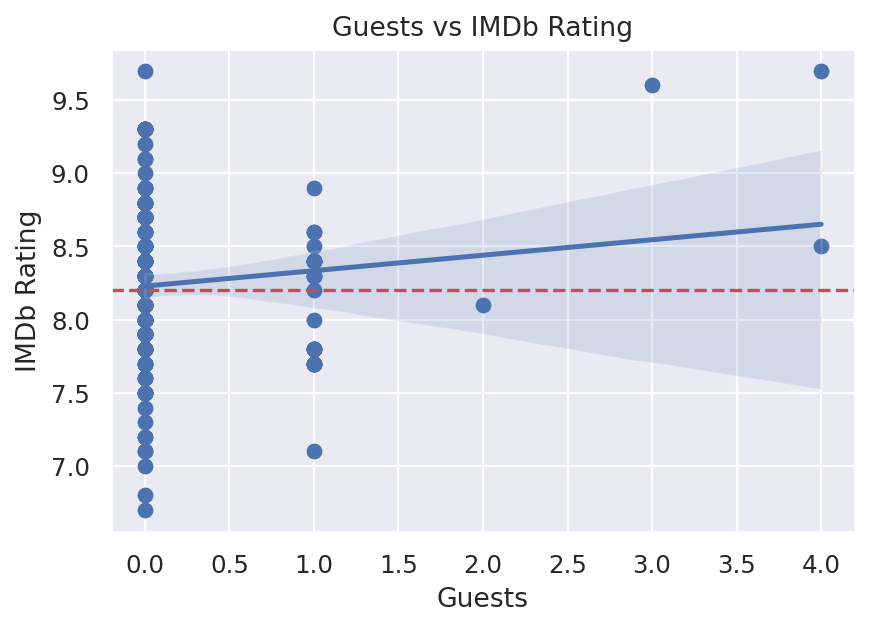

In [93]:
# Seeing if there is a correlation between no. of guest stars and imdb_rating
df_['Guests'] = df_['GuestStars'].apply(lambda x: 0 if pd.isnull(x) else x.count(",") + 1)

# Create a smaller plot
fig, ax = plt.subplots(figsize=(6,4))

# Plot the scatter plot
ax.scatter(df_['Guests'], df_['imdb_rating'])


# Plot the horizontal line
ax.axhline(y=8.2, color='r', linestyle='--')

sns.regplot(x=df_['Guests'], y=df_['imdb_rating'], ax=ax)

# Set labels and title
ax.set_xlabel('Guests')
ax.set_ylabel('IMDb Rating')
ax.set_title('Guests vs IMDb Rating')

plt.show()

As we can see in the figure above, there is a slight positive correlation between the number of guest stars and the imdb\_rating. Unfortunately, there are only 4 data points for episodes with more than 1 guest star. There is no clear indication of whether having guest star increases the IMDB rating or not, given the small number of episodes in which guest stars were featured. We can infer from the scatter plot that the range of IMDB ratings for episodes with more than one guest star has a greater lower bound than the corresponding range for star\-less episodes. In other words, episodes with one or more guest stars have ratings ranging from 7.2 to the highest rating of 9.8, while episodes not featuring a guest star have a larger spread, with IMDB ratings in the range \[6.5, 9.8\].

It is worth noting that, among the episodes featuring a guest star, the highest IMDB rating of 9.8 occurred for the "Finale," which is the final episode of the last season. Moreover, this episode has received 7934 votes, which is an outlier in the <span style='font-family:Courier'>total\_votes</span> dimension, as $Q_3$ is at $2385$. Therefore, we cannot necessarily attribute the high rating solely to the guest stars, and we should be cautious about placing too much weight on their presence. 

We encoded the <span style='font-family:Courier'>GuestStars </span>column into _0s,_ for episodes with no guest stars, and _1s,_ for episodes with at least 1 guest star. We opted for a binary classification as there are few episodes with more than one guest and since we are not able to measure individual guest's fame \(their individual impact/resonance they have on the viewer\) i.e. different guests might have different effects on the episode rating.


In [94]:
df_['Guests'] = df_['GuestStars'].apply(lambda x: 0 if pd.isnull(x) else 1)

#### 2.3.3 Encoding stand alone episodes vs two part episodes \(<span style='font-family:Courier'>is\_part</span>\)

We suspected that the reason _duration_ has such a strong positive correlation with the _imdb\_rating_  is because the longest episodes will probably be the ones that are a part of two\-series episodes. To test that theory, we have created a new feature _is\_part_ which assigns 0s to independent episodes and 1s to episodes which are multi\-part.



In [95]:
#Regex is causing a warning, which suggests to use str.extract instead of str.contains, but it is not what I needed so I muted the warning
import warnings
warnings.filterwarnings("ignore", message="This pattern is interpreted as a regular expression, and has match groups.")
import re

#Create a new column for encoding part1&2 as a feature
df_['is_part'] = pd.Series([0] * len(df))

# This code is creating a column which contains binary information. Whether an episode is a 2 parter (1), or a single individual episode (0)
pattern = r'\b(?<!party\s)(Parts?|Part \d+)\b' #Regular expression which includes 'Part' and 'Parts', but ignores 'party'.
for index, row in df_.iterrows():
    if re.search(pattern, row['episode_name']):
        df_.loc[index, 'is_part'] = 1

To check whether the stand alone episodes get rated lower on average than the episodes which consist of several parts we plotted a graph and calculated the % difference of the means. As we can see, the independent episodes on average have 7% lower rating than the multi\-part episodes.


The independent episodes get on average 7.43% lower rating


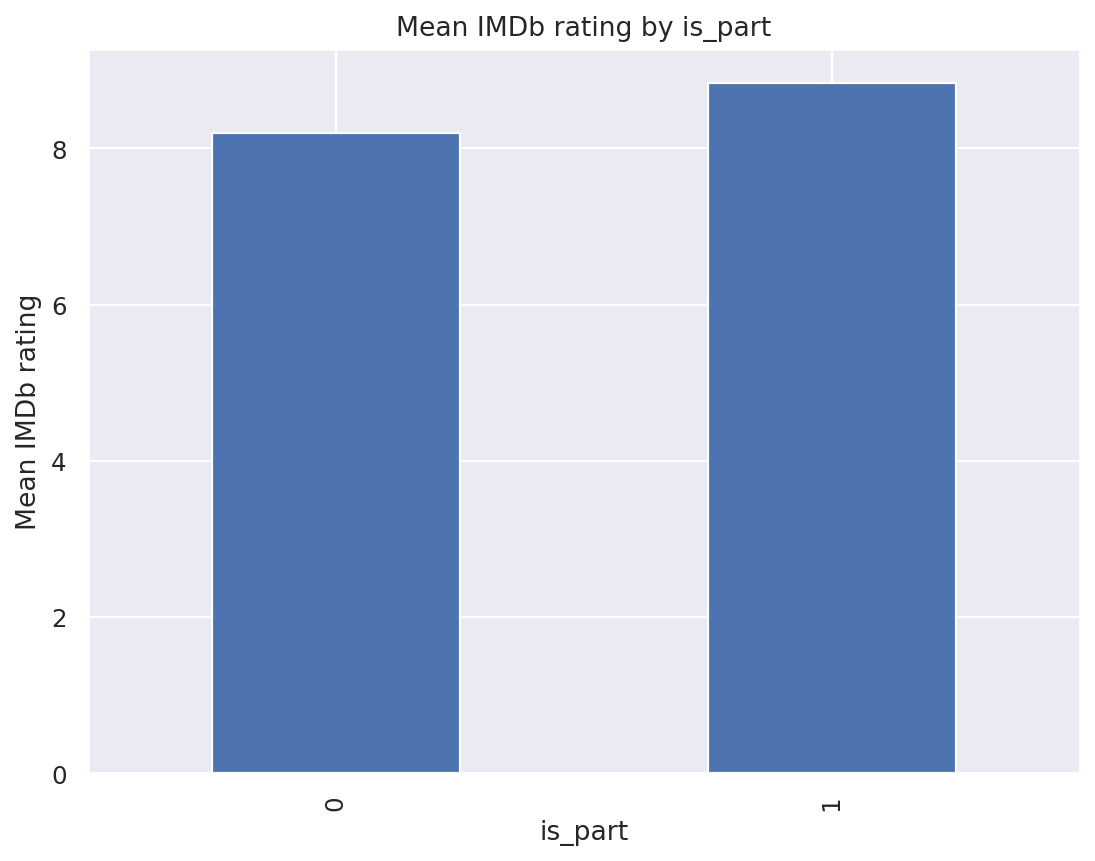

In [96]:
# group the data by 'is_part' and calculate the mean IMDb rating
grouped = df_.groupby('is_part')['imdb_rating'].mean()

percent_diff = abs(grouped.loc[0] - grouped.loc[1]) / ((grouped.loc[0] + grouped.loc[1]) / 2) * 100
print(f"The independent episodes get on average {percent_diff:.2f}% lower rating")

# create a bar plot of the mean IMDb ratings
plt.figure(figsize=(8,6))
grouped.plot(kind='bar')
plt.title('Mean IMDb rating by is_part')
plt.xlabel('is_part')
plt.ylabel('Mean IMDb rating')
plt.show()

### **2.4 Dropping \(unnecessary\) features:**

We may now drop unnecessary features from the dataframe. Additional features are dropped as they caused issues during the model fitting stage downstream. Choosing which features to drop is a crucial part of any implementation of supervised learning and as such we will thoroughly justify our decisions during this step of the analysis. We motivate our discussion of rank deficiency issues by considering the dummy variables for the most commonly appearing main characters.

Below, we print the names and number of appearances for main characters that appeared in more than 180 of the 185 episodes in the dataset. Note that "Dwight" appears as a main character in every episode from the dataset, "Jim" appears as a main character in all but one episode, and "Pam" in all but four :



In [97]:
for name in list(df_.columns):
    if ("mc" in name and df_[name].sum() > 180):
        print(f"Number of episodes in which {name[3:]} appeared as a main character: ", df_[name].sum())
print("Total nr of episodes: ", df_.shape[0])
print()
print("Episode in which Jim does not appear as main character:")
display(df_[df_["mc_Jim"]==0])

print("Episodes in which Pam does not appear as main character:")
display(df_[df_["mc_Pam"]==0])

Number of episodes in which Dwight appeared as a main character:  185
Number of episodes in which Pam appeared as a main character:  181
Number of episodes in which Jim appeared as a main character:  184
Total nr of episodes:  185

Episode in which Jim does not appear as main character:


season  episode episode_name       director         writer  imdb_rating  \
102       6       14   The Banker  Jeffrey Blitz  Jason Kessler          6.8   

     total_votes    air_date  n_lines  n_directions  ...  mc_Kevin  \
102         2288  2010-01-21    131.0            25  ...         1   

     mc_Phyllis mc_Angela  mc_Michael mc_Toby  mc_Meredith  mc_Erin  mc_Oscar  \
102           0         1           1       1            0        0         0   

     Guests  is_part  
102       0        0  

[1 rows x 134 columns]

Episodes in which Pam does not appear as main character:


season  episode      episode_name           director          writer  \
146       8        9   Mrs. California     Charlie Grandy     Dan Greaney   
147       8       10  Christmas Wishes           Ed Helms    Mindy Kaling   
148       8       11            Trivia         B.J. Novak      Steve Hely   
149       8       12        Pool Party  Charles McDougall  Owen Ellickson   

     imdb_rating  total_votes    air_date  n_lines  n_directions  ...  \
146          7.7         1553  2011-12-01    278.0            49  ...   
147          8.0         1547  2011-12-08    310.0            49  ...   
148          7.9         1488  2012-01-12    237.0            44  ...   
149          8.0         1612  2012-01-19    273.0            62  ...   

     mc_Kevin  mc_Phyllis mc_Angela  mc_Michael mc_Toby  mc_Meredith  mc_Erin  \
146         1           1         1           0       1            0        1   
147         1           1         1           0       1            1        1   
148         1           1         1           0       0            1        1   
149         1           1         1           0       1            1        1   

     mc_Oscar  Guests  is_part  
146         1       1        0  
147         1       0        0  
148         1       0        0  
149         1       0        0  

[4 rows x 134 columns]

In order to avoid rank\-deficiency of our design matrix during model fitting, we see immediately that we must remove the column "mc\_Dwight". 

Consider then the entries in column "mc\_Jim". Before model fitting a the dataset will be split into a training and a test set, respectively. During cross\-validation, the training set will be sub\-split into 5 folds, with one fold being assigned for validation. This process, of sub\-splitting the training set, is repeated 5 times, such that each of the folds from the training set, acts a validation set exactly once. 

See first that if "The Banker" is included in the test set, the training set will have all 1's in the "mc\_Jim"\-column. Consequently, the training set will be rank deficient when an intercept is included for model fitting. Conversely, assume now that "The Banker" is NOT assigned to the test set. During cross\-validation, we see that "The Banker" will be assigned to the validation fold exactly once. In this case, the remaining 4 folds will have all 1's in the "mc\_Jim"\-column, again causing linear dependence with the intercept during model fitting \(that is, model fitting within the cross\-validation\). It follows that we must drop the "mc\-Jim" feature. The consequence is that we cannot quantify the effect of "Jim" appearing as a main character on imdb ratings. By our reasoning, this is justified, however, as the size of the subset within which "Jim" does NOT appear is too small to inform any discussion of the effect of his presence as a main character.

In a similar vein to the discussion for "mc\_Jim", note that if all episodes in which "Pam" does not appear are assigned to the testing set, the remaining training set will be rank\-deficient when an intercept column is included. Furthermore, note that if only one of these episodes are in the training set, rank\-deficiency will occur during cross validation in the same way as was explained for "mc\_Jim". Hence, when the data is split, we must ensure that in the training set at least two contain entries episodes in which "Pam" did not appear as a main character.

By the same reasoning with which we concluded that "mc\_Jim" must be excluded from the dataset, we see that the dummy\-variable for every writer and director appearing in only one episode must also be dropped from the dataset. \(In this case there will be rank\-deficiency due to a majority of 0's rather than 1s\). We have chosen, however, to exclude the one\-hot variables for every director and writer who contributed on less than 5 episodes. While less than ideal, this approach ensures we have enough data to assess individual writer/director effects. The reasoning is that the director/writer variables which are excluded would not contain enough non\-zero entries for cross\-validation to be effective in optimisation of model hyper\-parameters and for the fitted models to have good predictive power. 

The last step we must take to avoid linear dependence in our training data is to remove the one\-hot variables for episodes released on a Sunday and on a Tuesday. 

Below we have printed the number of episodes released on a Sunday, Tuesday, and Thursday, respectively



In [98]:
days=['Sunday','Tuesday','Thursday']
for day in days:
    print(f"Number of episodes released on a {day}: ", df_[f"{day}"].sum())
print("Episode released on a Sunday: ")
df_[df_["Sunday"]==1]

Number of episodes released on a Sunday:  1
Number of episodes released on a Tuesday:  15
Number of episodes released on a Thursday:  169
Episode released on a Sunday: 


season  episode               episode_name       director  \
77       5       14  Stress Relief (Parts 1&2)  Jeffrey Blitz   

              writer  imdb_rating  total_votes    air_date  n_lines  \
77  Paul Lieberstein          9.6         5948  2009-02-01    416.0   

    n_directions  ...  mc_Kevin  mc_Phyllis mc_Angela  mc_Michael mc_Toby  \
77            93  ...         1           1         1           1       0   

    mc_Meredith  mc_Erin  mc_Oscar  Guests  is_part  
77            1        0         1       1        1  

[1 rows x 134 columns]

Note first that at least one of the one\-hot variables indicating weekday of release must be removed since their sum would be linearly dependent with the intercept column in the design matrix for the training data. It makes sense to drop the "Sunday" variable since cross validation would lead to rank\-deficiency when the single non\-zero entry \("Stress Relief"\) is included in the validation or test sets. Consider then the case where the "Sunday" variable is removed. If "Stress Relief" is assigned to the test set, the sum of columns "Tuesday" and "Thursday" will equal the intercept column, causing rank\-deficiency for the remaining data.  On the other hand, if "Stress Relief" is not in the test set, it will be assigned to the validation fold during cross\-validation at least once. In the design matrix corresponding to the remaining collection of folds, the sum of "Tuesday" and "Thursday" columns will again equal the intercept, causing rank\-deficiency. It follows that we must also eliminate either variable "Thursday" or variable "Tuesday". We choose to drop the "Tuesday" variable so as to allow a comparison between episodes released on a Thursday and episodes released on any other day \(the vast majority of episodes were released on a Thursday\).

As we shall see in the next section on fitting regression models, the result of keeping only director/writer variables with at least 5 non\-zero entries is that the influence on rating of other directors/writers will be collectively included in an intercept term. Similarly, keeping only the "Thursday" dummy\-variable for day of release causes the effect of other release\-days to be contained in the intercept. 

With regards to the other variables in our dataset, note that we have no way of encoding "episode\_name" as a numerical variable, and so this column is also dropped. We encoded the writer and director above, so these variables may also be dropped now. Our work aims at finding the most important features to maximise ratings of a reunion episode, and so the "season" and "episode" variables are also tossed out. We also remove the 'total\_votes' column, as we expect NBC to have little direct control over the number of votes cast. Finally, "GuestStars", "air\_date", and "air\_day" have all been encoded in one\-hot or dummy variables, and so may be tossed out at this point. 

The cell directly below effectuates all changes discussed above in our dataset.



In [99]:
# Select columns starting with 'w_' or 'dir_'
cols_to_sum = df_.filter(regex='^(w_|dir_)')

# Calculate the sum of each individual column
sum_cols = cols_to_sum.sum()

# Select columns where the sum is greater than or equal to 5
selected_cols = df_[sum_cols[sum_cols >= 5].index]

# Concatenate the selected columns with the other columns in the original dataframe
df_ = pd.concat([df_.drop(cols_to_sum.columns, axis=1), selected_cols], axis=1)

#remove sunday variable in order to avaid colinearity with intercept term
drop_df = df_.drop(columns = ["Sunday", "Tuesday", "director", "writer", "main_chars", "episode_name", "season", "episode", "GuestStars", 'air_date', 'air_day', 'total_votes', "mc_Dwight", "mc_Jim"])

#print number of columns and rank in remaining data (excluding the response) when concatenated with an intercept column
check_rank = np.c_[np.ones(185), np.array(drop_df.drop("imdb_rating", axis = 1))]
print('Nr of Columns: ', check_rank.shape[1])
print('Rank: ', np.linalg.matrix_rank(check_rank))

Nr of Columns:  50
Rank:  48


### 2.5 Feature Correlation



We have reduced the number of columns in the data to 50 \(when including an intercept column of all 1's\ and exluding the imdb_rating). However, the rank is only 48. Below, we make a correlation plot to investigate any further interactions among the remaining variables.



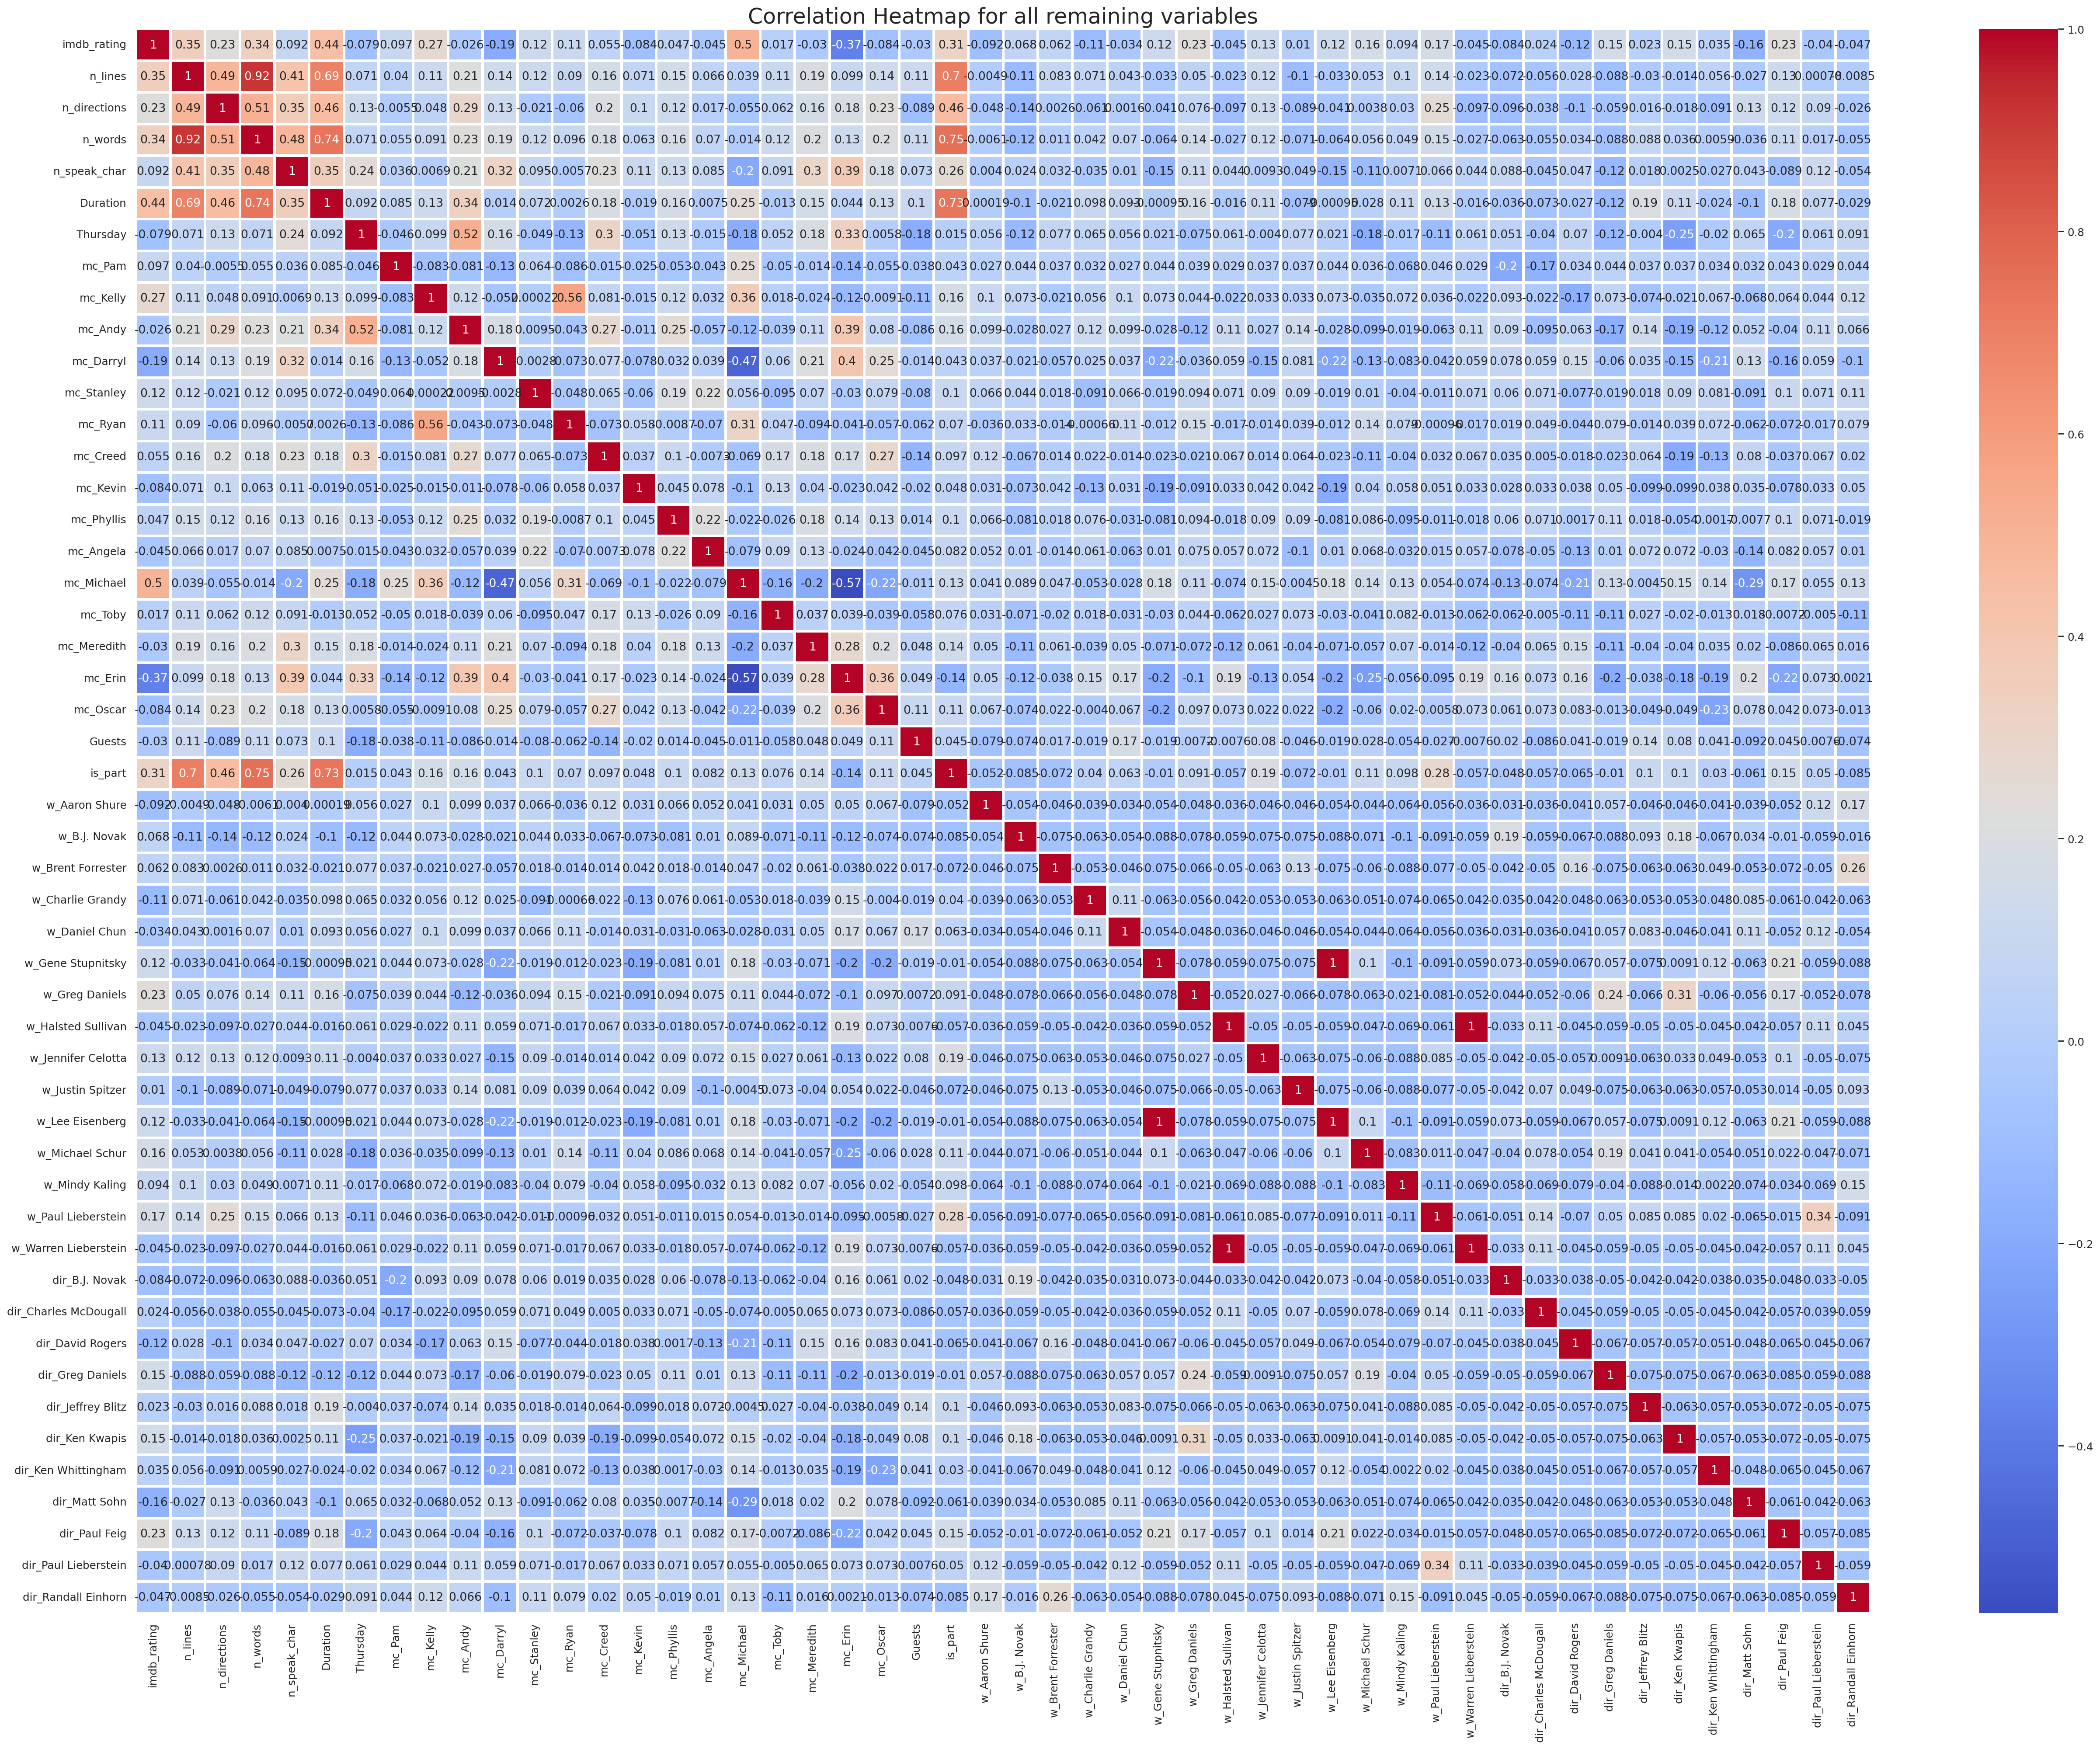

In [100]:
# Produce a Heat Map
explore_set = drop_df.copy()
sns.set(rc={'figure.figsize': (40, 30)})
sns.heatmap(explore_set.corr(),cmap='coolwarm', annot = True, linewidths = 2)
plt.title("Correlation Heatmap for all remaining variables", size = 22)
plt.show()

We note that the entries in "w\_Lee Eisenberg" are perfectly correlated with the entries in "w\_Gene Stupnitsky". Similarly, the entries in "w\_Warren Lieberstein" are perfectly correlated with the entries in "w\_Halsted Sullivan". This suggests that each of the writers in these two pairs always worked with the other writer in the same pair. To avoid linear dependence we must combine the columns for each pair into a single variable, respectively.   
These changes are enacted below.


In [101]:
drop_df = drop_df.rename(columns = {"w_Lee Eisenberg": "w_ Eisenberg & Stupnitsky", "w_Warren Lieberstein": "w_ Lieberstein & Sullivan"})
drop_df = drop_df.drop(["w_Gene Stupnitsky", "w_Halsted Sullivan"], axis=1)

## 3. Model Fitting and Tuning



<span style='color:#f44336'>**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**</span>



### 3.1 Splitting data

We split our data, as is good practice when developing an ML model. Splitting data is integral to interpreting the information on which the model is built and tested.

We pass an integer \(42\) to <span style='font-family:Courier'>random\_state</span> for reproducible output across executions of the script. We also pass a parameter to specify the size of the test data, which we set as $20\%$ of the whole dataset, in line with industry standard. Such splitting provides 37 observations in the test set, so that 5\-fold cross\-validation may be performed on the remaining data, with either 29 or 30 observations in each fold, respectively. Before fitting each model, we applied min\-max scaling to the data. There were several reasons why we made this choice of scaling. Firstly, min\-max scaling reduced the range of every variable to the interval \[0,1\], making it easier to compare the varying coefficients for different variables. Second, min\-max scaling leaves binary \(dummy\) variables unchanged, allowing for very simple interpretation of the resulting coefficients.

We considered using several regression models for our analysis, including lasso regression, ridge  regression, polynomial regression, and decision tree regression. We have created some functions in order to standardise the process of calculating the RMSE, MSE and $R^2$ values, and of getting an array of coefficients for the regression models, including the intercept term if available. These functions were partially drawn from the workshop material and are shown below.



In [102]:
#Split data

X = drop_df.drop("imdb_rating", axis = 1) # Set of features
y = np.array(drop_df["imdb_rating"]) #response

#Split Data into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2, shuffle = True)

#Setting a fixed variable for KFold so that cross validation is standardised across model evaluations
kf=KFold(5)

In [103]:
#Use part of model_fit function from workshop to extract information on goodness of fit
def model_fit(m, X, y):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values."""
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    return Metrics

In [104]:
#Use function from workshops to extract coefficients from models
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

To optimise the hyperparameters for the lasso, ridge, and polynomial regression, a 5\-fold cross\-validation method was applied to the training set for each model. During cross-validation, we plit the training data into 5 folds in the same manner for each model. We mentioned above that when each fold acts as a validation set once, we must ensure that the design matrix as constructed from the remaining for folds is of full rank. The code below confirms that our training data does indeed maintain full rank during cross-validation. 

In [110]:
print("The number of columns in the training data when combined with an intercept:", X_train.shape[1]+1)

for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    validation_length = len(train_index)
    remainder = np.c_[np.ones(validation_length), np.array(X_train)[train_index]]
    print(f"When fold {i} acts as validation set, remaining trainng data (including intercept column) has rank", np.linalg.matrix_rank(remainder))

The number of columns in the training data when combined with an intercept: 48
When fold 0 acts as validation set, remaining trainng data (including intercept column) has rank 48
When fold 1 acts as validation set, remaining trainng data (including intercept column) has rank 48
When fold 2 acts as validation set, remaining trainng data (including intercept column) has rank 48
When fold 3 acts as validation set, remaining trainng data (including intercept column) has rank 48
When fold 4 acts as validation set, remaining trainng data (including intercept column) has rank 48


After fitting each model, the RMSE when predicting for the test set was used as the final measure of performance.

For example, in Terms of Lasso regression model we:

1. Performed optimisation of the hyperparameters  \($\alpha$\) using 5-fold cross\-validation on the training data
2. Train the Lasso regression model using the optimal hyperparameter found in \(1\) and the entirety of the training data
3. Measure the final performance of the model by finding RMSE with respect to test set

Note that, we have dropped the one-hot variables "Dwight" as a main character, an episode airing on a Tuesday or Sunday, and for all directors and writers who worked on less than 5 episodes. It follows that these variables form a base for each model in the sense that the intercept gives information about the predicted rating when "Dwight" is included as a main character, the episode airs on a Tuesday or Sunday, and the episode is written by a team of less experienced directors and writers.

For each model, we chose the root mean squared error, relative to a prediction on the test set, as a measure of performance.

We found that: 

Lasso regression: For an optimal hyperparameter, $\alpha$, of $0.01535$;  $RMSE = 0.3607$ 

Ridge regression: For an optimal hyperparameter, $\alpha$, of $
5.91466$;  $RMSE = 0.3709$ 

Polynomial regression: For an optimal degree of 1 (in each variable); $RMSE = 0.4516$

Decision tree: For optimal maximum depth of 2, and minimum observations at each leaf 8; $RMSE = 0.3855$

The model with the lowest root mean squared error was the Lasso Regression model. The code implementation for Lasso, including hyperparameter determination via cross-validation, is included below. 

### 3.3 Lasso model



In [106]:
#Array of possible hyperparameters alpha
alphas = np.logspace(-3, 0, num=1000)

#perform gridsearch for optimal alpha on training data
gs = GridSearchCV(
    make_pipeline(
        MinMaxScaler(),
        Lasso()
    ),
    param_grid = {'lasso__alpha': alphas},
    cv = kf,
    scoring = "neg_root_mean_squared_error"
)

gs_lasso = gs.fit(X_train,y_train)

In [111]:
#print optimal hyperparameter
print(np.round(gs_lasso.best_params_['lasso__alpha'], 5))

#print corresponding best RMSE from cross-validation
print(abs(gs_lasso.best_score_))

0.01535
0.4685128702498947


In [113]:
#Make pipeline to fit model given hyperparameter
lasso_full = make_pipeline(
       MinMaxScaler(),
       Lasso(alpha = 0.01535)
    )

#Fit the model on the entire set of training data
full_lasso = lasso_full.fit(X_train,y_train)

#print MSE, RMSE, and R2 values when model is evaluated against test set
metrics = model_fit(full_lasso, X_test, y_test)
print("MSE: ", metrics[0], ", RMSE: ", metrics[1], ", R^2: ", metrics[2])
print()

model_coefs = get_coefs(full_lasso)

coef_dict ={}
coef_dict["Intercept"] = model_coefs[0]
for i in range(1, X.shape[1]):
    if model_coefs[i] != 0:
        coef_dict[X.columns[i-1]] = model_coefs[i]
    
print("Lasso Model: Nonzero coefficients and corresponding variables:")
print(coef_dict)

MSE:  0.1301 , RMSE:  0.3607 , R^2:  0.4426
Lasso Model: Nonzero coefficients and corresponding variables:
{'Intercept': 7.901362191377476, 'n_lines': 0.0805484096476479, 'Duration': 0.5751274240886944, 'mc_Kelly': 0.08998829311466246, 'mc_Creed': 0.003017829648279455, 'mc_Michael': 0.30392562022155367, 'mc_Toby': 0.022320576318947932, 'mc_Erin': -0.15037806775338178, 'w_Greg Daniels': 0.09956864505207755, 'w_Paul Lieberstein': 0.10588592913551816, 'dir_Paul Feig': 0.018293782184308667}


We note that for several of the variables, the coefficients have been suppressed to zero by the Lasso model. The features that had non\-zero coefficients, i.e. the most significnant effect on <span style='font-family:Courier'>imbd\_rating </span>, are listed below:

- Duration 
- mc\_Michael
- mc\_Erin
- w\_Paul Lieberstein
- w\_Greg Daniels
- mc\_Kelly
- n\_lines
- mc\_Toby
- dir\_Paul Feig
- mc\_Creed

<span style='font-family:Arial'>In </span><span style='font-family:Arial'>**2.5 Feature Correlation**</span><span style='font-family:Arial'>,</span><span style='font-family:Courier'> duration, is\_part</span> and <span style='font-family:Courier'>n\_lines</span> were strongly correlated in the heatmap, which could contribute to fact that the lasso model supressed their coefficients entirely here. Logically, the <span style='font-family:Courier'>duration </span>parameter and <span style='font-family:Courier'>n\_lines</span> features are intrinsically linked to an episode's status as a multi\-part episode, so the model is unable to determine that part status is not important, as the suppression might be purely because of said correlation.

It would be preferable to split the part 1&2 episodes instead of merging them, as this would allow us to decouple the effects of the duration and is_part features Due to the fact that the needed information was not provided in the original dataset, we were not able to split these episodes.



When categorical features are one-hot encoded and then scaled to a standard normal distribution (with standarisation), such as our characters, writers and dircors in this case, interpreting the coefficients becomes a bit more complicated. One way to interpret the coefficients is to consider the effect of each level of the categorical variable on the response variable, after adjusting for the effects of all the other variables in the model.

To do this we scale our one-hot encoded variables using standard scaling  to have zero mean and unit variance. This is doneto easily interpret the coefficients by multiplying them by the corresponding coefficient value. We have $8$ categorical variables and we will aplply the standard scaling.

In [133]:
print(coef_dict)

{'Intercept': 7.901362191377476, 'n_lines': 0.0805484096476479, 'Duration': 0.5751274240886944, 'mc_Kelly': 0.08998829311466246, 'mc_Creed': 0.003017829648279455, 'mc_Michael': 0.30392562022155367, 'mc_Toby': 0.022320576318947932, 'mc_Erin': -0.15037806775338178, 'w_Greg Daniels': 0.09956864505207755, 'w_Paul Lieberstein': 0.10588592913551816, 'dir_Paul Feig': 0.018293782184308667}


In [0]:
first_key = list(coef_dict.keys())[0]
coef_dict.pop(first_key)

In [132]:
coef = coef_dict
for i in range(len(coef_dict)):
    print(coef_dict[i] + ": " + str(np.unique(scaled_cat_vars_df.iloc[:, i])) * model_coefs[model_coefs !=0])

KeyError: 0

## 4. Discussion and Conclusions



*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**



### <span style='color:#f44336'>Model implications, performance and drawbacks</span>

<span style='color:#f44336'>As we can observe, the most influential feature </span>in predicting <span style='font-family:Courier'>imdb\_rating </span>is the duration of the episode, which we have combined for parts 1 & 2. This aligns with the common expectation that the finale of a season tends to be a more heavily watched episode with a higher <span style='font-family:Courier'>imdb\_rating</span>. Additionally, characters such as Michael, Kelly, Toby, and Creed have a positive impact on the rating, while Erin does not. Similarly, the number of lines also appears to play a role in determining the rating.

\[\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\]

### <span style='color:#ff5722'>Writer and director caveats</span>

<span style='color:#ff5722'>The effects of numerous directors and writers were ultimately indiscernible in our final model. Several factors contributed to this:</span>

- <span style='color:#ff5722'>Due to their perfect correlation shown in </span><span style='color:#ff5722'>**2.5 Feature Correlation**</span><span style='color:#ff5722'>, we cannot be ascertain the effects of the writers Lee Eisenberg, Gene Stupnitsky, Warren Lieberstein or Halsted Sullivan as they always worked in pairs, making their individual influence on IMD rating impossible to determine in any of our models. This may be a point of further investigation in subsequent analyses.</span>
- <span style='color:#ff5722'>As discussed in </span><span style='color:#ff5722'>**3. Model Fitting and Tuning**</span><span style='color:#ff5722'> several directors and writers who were assigned to few episodes created rank deficiency in our statistical modelling, weakening the ability to make predicitons during the model Cross Validation stages. Their collective effect had to be included in the intercept instead, so their individual effect could not be calculated.</span>
  - <span style='color:#ff5722'>In truth, they might have had good performance and improved imdb\_rating, but we would expect that employing the writers and directors named below instead would give a higher imdb\_rating relative to all the directors and writers with fewer than 5 episodes in the reunion episode based on our model.</span>

<span style='color:#ff5722'>Conversely, of our recommended directors, director Paul Feig completed three episodes with Greg Daniels as the writer and these episodes have received high </span><span style='font-family:Courier'><span style='color:#ff5722'>imdb\_scores </span></span><span style='color:#ff5722'>of 9.3, 8.2, and 9.7. This reinforces the idea that they work well together to deliver the best possible episode. Although both writers are also directors, they seem to perform better when focusing solely on writing.</span>

<span style='color:#ff5722'>\\n</span>

<span style='color:#ff5722'>\\n</span>

<span style='color:#ff5722'>Our model's implementation of minmax scaling is a key component of managing the dataset's heterogeneity, however it's interpretation should be handled carefully. Whilst we can state that </span><span style='color:#ff5722'><span style='font-family:Courier'>duration </span></span><span style='color:#ff5722'>is highly influential, its stronger coefficient only shows the change in </span><span style='font-family:Courier'><span style='color:#ff5722'>imdb\_rating</span></span><span style='color:#ff5722'> that we would expect if </span><span style='color:#ff5722'><span style='font-family:Courier'>duration </span></span><span style='color:#ff5722'>were increased by an entire increment of range found in training data.  Care should also be taken to avoid comparisons between continuous features such as </span><span style='font-family:Courier'><span style='color:#ff5722'>duration</span></span><span style='color:#ff5722'> so can't compare to something like michael, maximise words and duration, include binary features with a non\-zero coef.</span>

As seen in Appendix\_\_, a polynomial model was tested using 5 fold Cross Validation for degrees of polynomial 1\-3 inclusive. Using GridSearch showed that the degree hyperparameter which allowed us describe the data best without overfitting to the training data was degree: 1, meaning a linear model was the most appropriate here. Although this instance of the model would have been more easily interpretable than polynomials of higher degree, this ‘polynomial model’ was disregarded as it produced the highest \(and thus least desirable\) RMSE of all our models \(RMSE= 0.53\).

\[\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\]

### Recommendations

Based on the final Lasso regression model, we can anticipate that a good imdb\_rating score is more likely to occur when Michael is included as a main character. To achieve an even higher score, it is advisable to exclude Erin as a character and incorporate as many lines as possible into the episode. Additionally, utilizing Paul Lieberstein or Greg Daniels as the writer and Paul Fieg as the director would yield the best results. Moreover, maximising episode duration and the number of lines, as well as including Kelly and Toby in the episode would be beneficial.

Though we did not include Dwight and Jim in our features, their appearance in all or most of the episodes allows us to logically assume that viewers would expect them to be part of the reunion as part of the show's identity. Furthermore, we reasoned that there is no mathematical basis to exclude them as there was no to little data showing the influence of their absence on an episode's rating. Hence, even without relying on the model, it is safe to say that they should be included in the reunion.

## Closing remarks

- <span style='color:#f44336'>not all of these features can be promised \(actors ofr writers not working anymore\),  collboration between all may not be possible, we recommend asking them in order of decreasing coef. \(given that previous is unavailable\)</span>



## 5. References

\(1\) Pedregosa F, Varoquaux G, Gramfort A, Michel V, Thirion B, Grisel O, et al. Scikit\-learn: Machine learning in python. Journal of machine learning research 2011 Oct 1,.

\(2\) Linblad B. schrutepy version 0.1.3. 2022 Jan 23,;0.1.3.

\(3\) Cohen A. fuzzywuzzy version 0.18.0. 2020 Feb 13,;0.18.0.

\(4\) Saleem MM. Exploring Interesting Information From The Office Dataset. 2021; Available at: https://www.datainsightonline.com/post/exploring\-interesting\-information\-from\-the\-office\-dataset. Accessed Feb 25, 2023.  



## 6.Appendix

We applied the following overall process for the other models which were tested:

- Minmax scale the training data
- Cross validate the fitted model for optimal hyperparameter
- Fit the model to entirety of the training data
- Test the efficiency of the model's predictive power against test data.

The code for these models and their associated MSE, RMSE, and $R^2$ scores are listed below. 

### Ridge Model



In [123]:
#Possibel hyperparameters
alphas = np.logspace(-3, 4, num=400)

#Grid search cross-validation on training data for optimal hyperparameter determination
gs = GridSearchCV(
    make_pipeline(
        MinMaxScaler(),
        Ridge()
    ),
    param_grid = {'ridge__alpha': alphas},
    cv = kf,
    scoring = "neg_root_mean_squared_error"
)

gs_ridge = gs.fit(X_train,y_train)

#Print optimal hyperparameter alpha and best RMSE score from cross-validation
print("Optimal paramter", np.round(gs_ridge.best_params_['ridge__alpha'], 5))
print("Best mean RMSE score for this value of alpha: ", abs(gs_ridge.best_score_))

Optimal paramter 5.91466
Best mean RMSE score for this value of alpha:  0.4573758902482


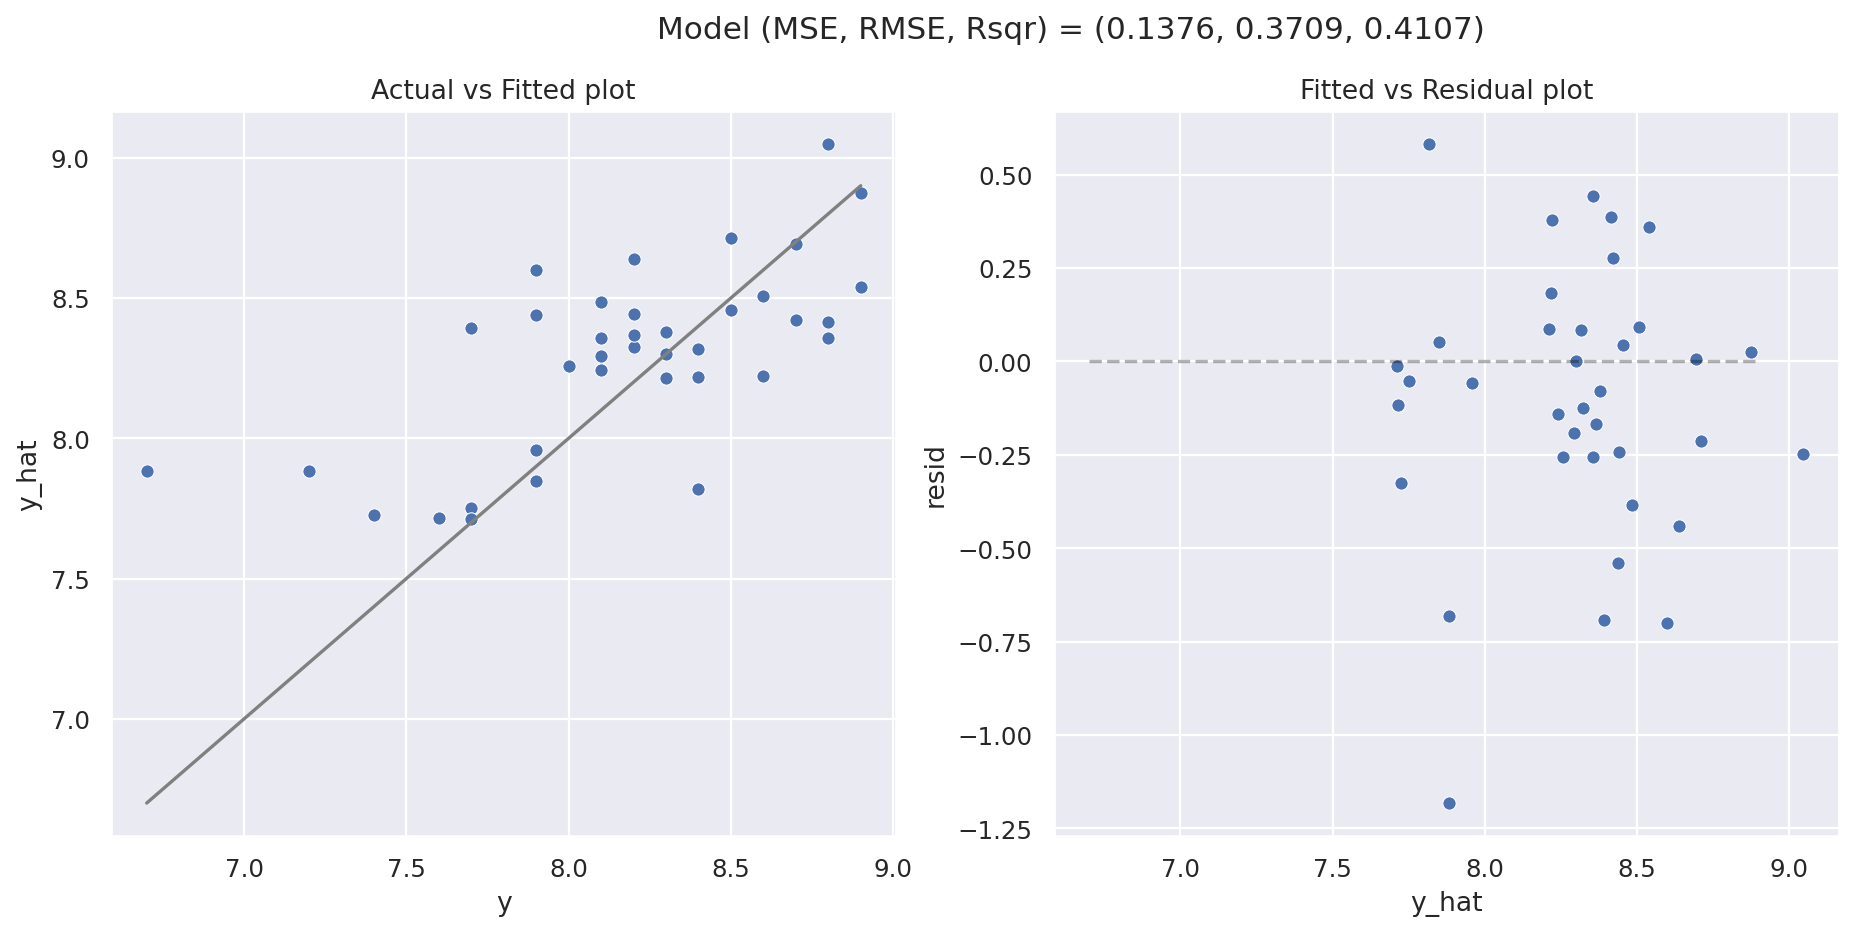

In [38]:
#Make pipeline for ridge regression with minmax scaling and alpha as above
ridge_full = make_pipeline(
       MinMaxScaler(),
       Ridge(alpha = 5.91466)
    )

#Fit the model
full_ridge = ridge_full.fit(X_train,y_train)

model_fit(full_ridge, X_test, y_test)
get_coefs(full_ridge)

model_coefs = get_coefs(full_ridge)

coef_dict_ridge ={}
coef_dict_ridge["Intercept"] = model_coefs[0]
for i in range(1, drop_df.shape[1]):
    coef_dict_ridge[drop_df.columns[i]] = model_coefs[i]
    
coef_dict_ridge

RMSE_results['Ridge']=coef_dict_ridge

RMSE_val['Ridge']=abs(gs_ridge.best_score_)

In [46]:
from sklearn.model_selection import cross_val_score

'''# Perform 5-fold cross-validation
cv_scores = cross_val_score(dtr, X_train, y_train, scoring = "neg_root_mean_squared_error", cv=5)

# Print the mean cross-validation score
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())'''

X_train_minmaxscaled = MinMaxScaler().fit_transform(X_train)
X_test_minmaxscaled = MinMaxScaler().fit_transform(X_test)

g_cv = GridSearchCV(DecisionTreeRegressor(random_state = 10),
              param_grid={'min_samples_split': range(2, 40), 'max_depth': range(2, 10), "min_samples_leaf":range(3,10)},
              scoring="neg_root_mean_squared_error", cv=kf, refit=True)

g_cv.fit(X_train_minmaxscaled, y_train)
print(g_cv.best_params_)
RMSE_val['Decision Tree']=abs(g_cv.best_score_)

{'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 2}


0.38552286722417317


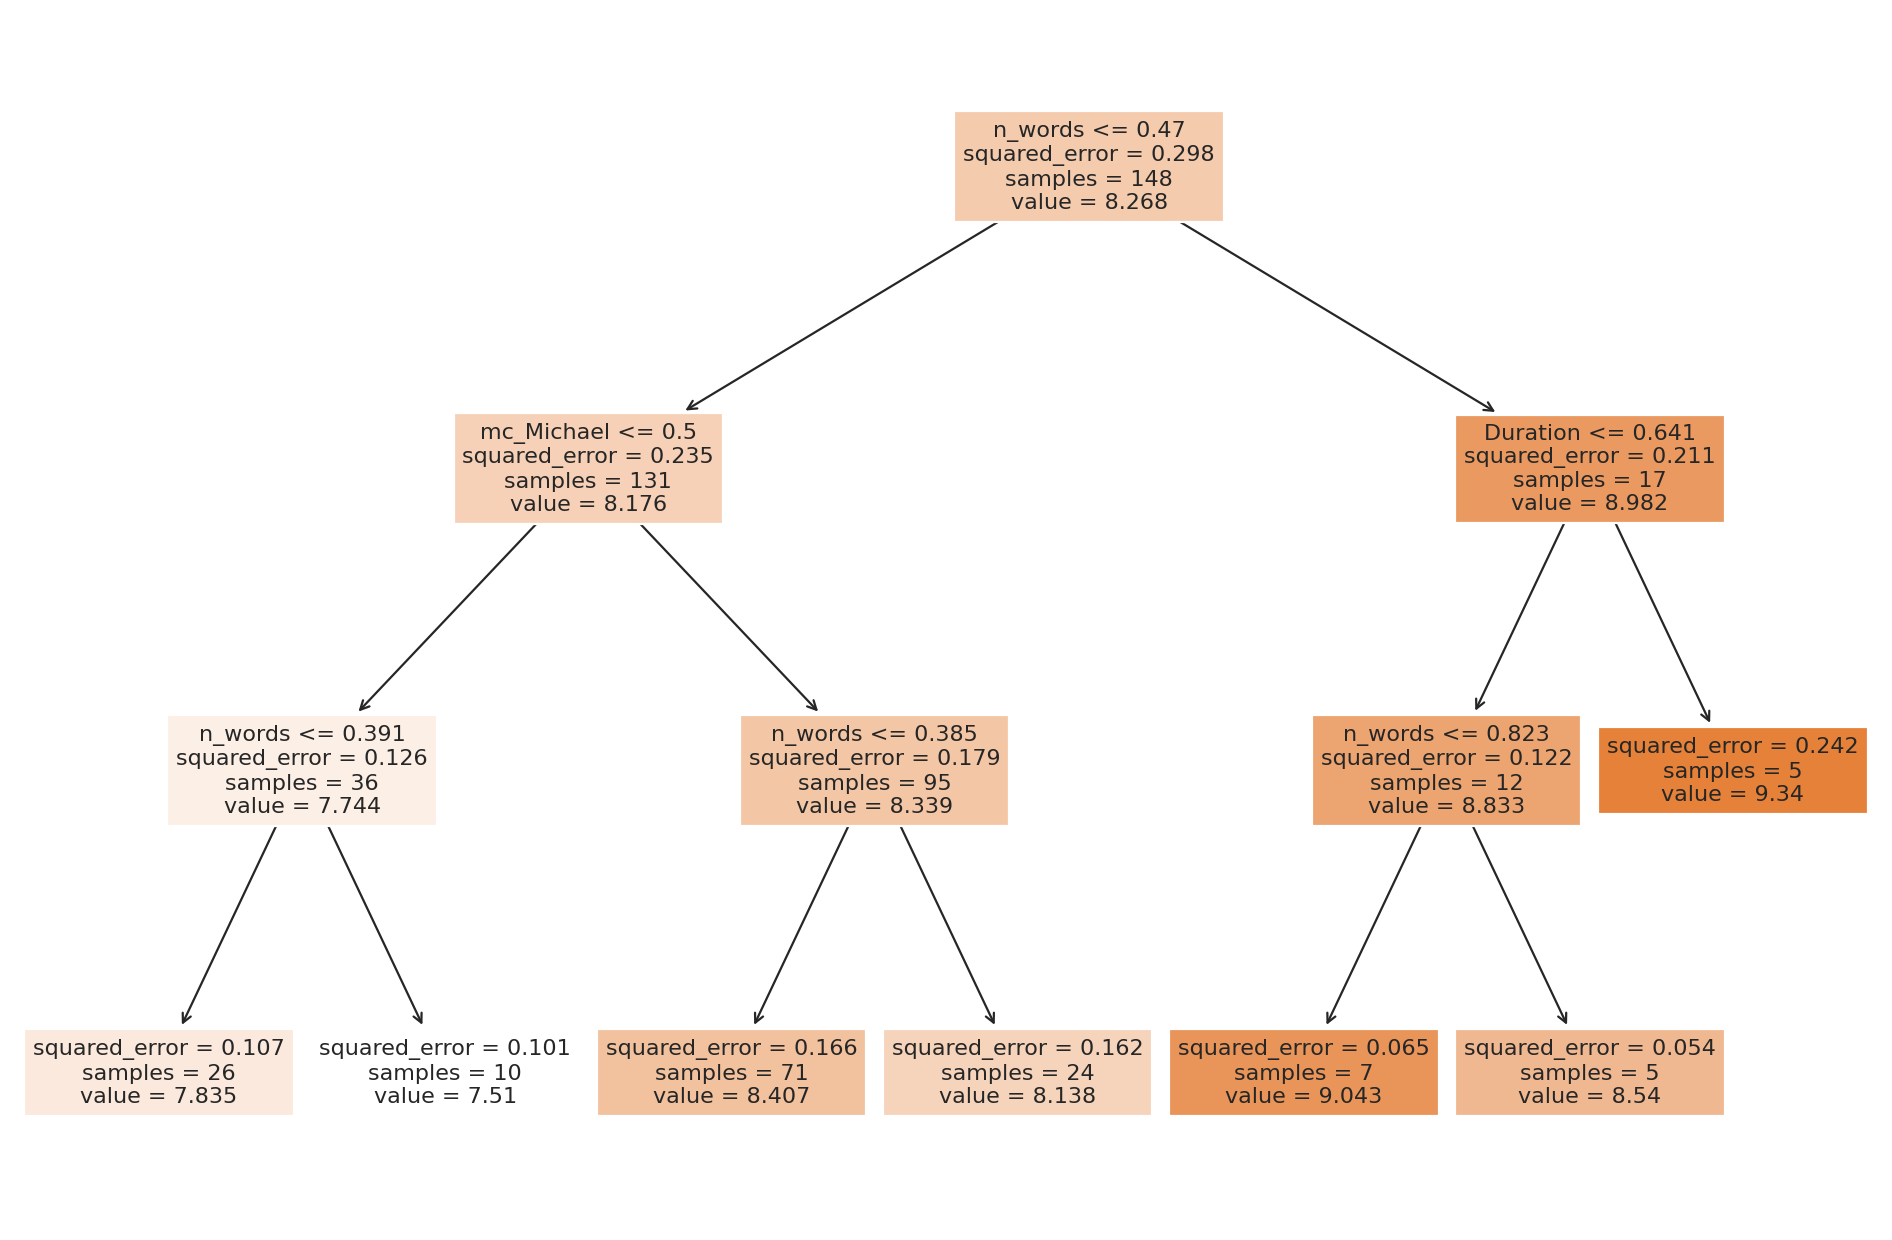

In [47]:
dtr2 = DecisionTreeRegressor(max_depth = 3, min_samples_split = 10, min_samples_leaf= 5)

#r2_score(y_test, g_cv.best_estimator_.predict(X_test))
tree_fit = dtr2.fit(X_train_minmaxscaled, y_train)

y_hat = tree_fit.predict(X_test_minmaxscaled)

print(np.sqrt(mean_squared_error(y_hat, y_test)))

fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(tree_fit, ax=ax, feature_names=X_train.columns, filled=True, fontsize=10)
plt.show()

%Using the scaled version of min max makes it easier to comment and compare on how far away the cutoff is with the inequality. In the first case though we are using the charater Michael, which has a binary code meaning we move to the left of the tree if Michael did not appear in an episode (=0) and moving to right if he did. 

### Polynomial model



In [54]:
#Adapted From workshop 5
#Building and corss validating a polynomial model

from sklearn.preprocessing import PolynomialFeatures

poly_pipe = make_pipeline(MinMaxScaler(),PolynomialFeatures(),LinearRegression())
parameters = {'polynomialfeatures__degree': np.arange(1,4,1)} #test polynomials from 0 to 3
Poly_grid_search = GridSearchCV(poly_pipe, parameters, cv = kf, scoring = "neg_root_mean_squared_error").fit(X_train, y_train)

Poly_grid_search

print(f"best param: {Poly_grid_search.best_params_}\nbest score: {Poly_grid_search.best_score_}")

# extract the cv_results dictionary
cv_results = Poly_grid_search.cv_results_; display(pd.DataFrame(cv_results))


#Gathering the polynomial coefs based on the best degree hyperparameter determined above
poly_pipe.set_params(polynomialfeatures__degree=1)
final_poly = poly_pipe.fit(X_train,y_train)
model_coefs=get_coefs(final_poly)
print("RMSE of FINAL MODEL WHEN COMPARED TO TEST SET:" , model_fit(final_poly, X_test, y_test)[1])

coef_dict_poly ={}
coef_dict_poly["Intercept"] = model_coefs[0]
for i in range(1, drop_df.shape[1]):
    coef_dict_poly[drop_df.columns[i]] = model_coefs[i]

#Add to results databank
#RMSE_results[f'Polynomial model (degree 1)']= ; 

#RMSE_val['Polynomial model (degree 1)']=abs(Poly_grid_search.best_score_)
#best score is a negative value, which translates 

best param: {'polynomialfeatures__degree': 1}
best score: -0.525118371517536


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.004006      0.000469         0.001375        0.000061   
1       0.106356      0.041711         0.022076        0.035538   
2       1.098823      0.426461         0.023421        0.028199   

  param_polynomialfeatures__degree                             params  \
0                                1  {'polynomialfeatures__degree': 1}   
1                                2  {'polynomialfeatures__degree': 2}   
2                                3  {'polynomialfeatures__degree': 3}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0          -0.437134          -0.459714          -0.695427          -0.546656   
1          -0.579804          -1.494512          -1.185832          -1.143236   
2          -0.514060          -1.297255          -0.961049          -0.980916   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0          -0.486661        -0.525118        0.092701                1  
1          -1.258083        -1.132293        0.301747                3  
2          -1.068599        -0.964376        0.254849                2

RMSE of FINAL MODEL WHEN COMPARED TO TEST SET: 0.4515976836671429
